In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit

In [162]:
k = 3
tau = 0.3
D = 1e-6
s = np.sqrt(2*D)
max_t = 5
dt = 6e-2
dx = 4e-4 #1e-4
border = 0.001

ntau = round(tau/dt)
ts = np.arange(0,max_t,dt)
ts_r = ts[1:]
x_s = np.arange(-0.003,0.003+1e-5,dx)
bins = np.arange(-0.003-dx/2,0.003+dx/2+1e-5,dx)

N_t = len(ts)
N_x = len(x_s)

def cusp_force(x,x_min):
    if x < 0:
        return -k*(x+x_min)
    else:
        return -k*(x-x_min)
cusp_force = np.vectorize(cusp_force)

def force(x,*args):
    return -k*x

In [163]:
tau/dt

5.0

In [175]:
R = np.zeros(( N_x, N_x))


F = force(x_s)
Fm = (F[1:]+F[:-1])/2
lp = D / dx**2 * np.exp((Fm*dx/D)/2)  # r_i->i+1
ln = D / dx**2 * np.exp(-(Fm*dx/D)/2)  # r_i+1->i

def get_prop(x):
    R[0,0] = -lp[x]
    R[-1,-1] = -ln[x]
    R[np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(lp[x]+ln[x]) # -(r_i->i+1 + r_i->i-1) ????
    R[np.arange(0,N_x-1),np.arange(1,N_x)] = ln[x]
    R[np.arange(1,N_x),np.arange(0,N_x-1)] = lp[x]
    prop = expm(R*dt)
    return prop

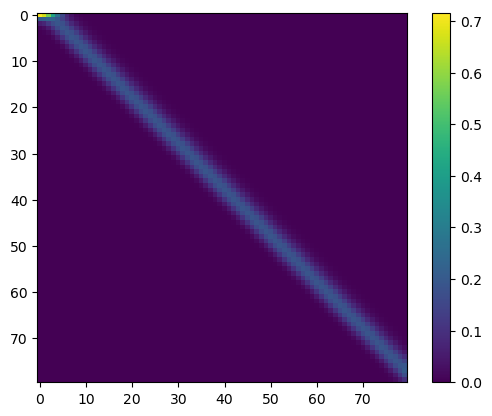

In [4]:
plt.imshow(get_prop(78))
plt.colorbar()

In [5]:
i_zero = np.argmin(x_s**2)

In [6]:
len(x_s)

80

In [7]:
ntau

5

In [44]:
# states = np.array([
# [40, 40, 40, 40, 40, 40],
# [20, 40, 40, 40, 40, 60]
# ])
# probs = [0.5,0.5]

In [135]:
states = np.full((1,ntau+1),i_zero,dtype=int)
probs = [1]

for i in tqdm(np.arange(7)):
    res_state = []
    new_states = []
    new_probs = []
    print('-------')
    for p,state in zip(probs, states):
        prob = get_prop(state[0])
        encoded_state = np.zeros(N_x, dtype = float)
        encoded_state[state[-1]] = 1
        #this_probs = (prob@encoded_state.T).T*p
        #i_s = np.where(this_probs > 0.0001)
        this_probs = (prob@encoded_state.T).T
        i_s = np.where(this_probs > 0.01)
        this_probs = this_probs[i_s]
        this_probs = this_probs/this_probs.sum()*p
        this_new_states = np.repeat(np.roll(state,-1)[None,:],len(i_s[0]),axis = 0)
        this_new_states[:,-1] = i_s[0]

        new_probs.extend(this_probs)
        new_states.extend(this_new_states)
    
    states = new_states
    probs = new_probs/np.sum(new_probs)

  0%|          | 0/7 [00:00<?, ?it/s]

-------
-------
-------
-------
-------
-------
-------


In [136]:
len(states), probs

(5196312,
 array([9.07143893e-12, 2.25279115e-11, 4.56890790e-11, ...,
        3.08140964e-11, 1.49673029e-11, 5.93723693e-12]))

In [137]:
np.sum(new_probs),np.sum(probs)

(0.9999999999999998, 0.9999999999999998)

In [138]:
final_state = np.stack(states)

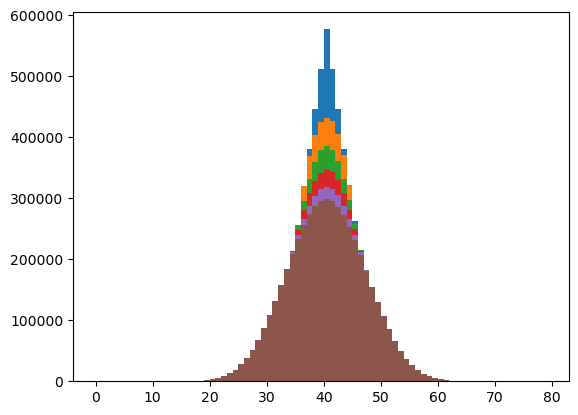

In [140]:
for fr in final_state.T:
    plt.hist(fr, bins = np.arange(0,N_x))
plt.show()

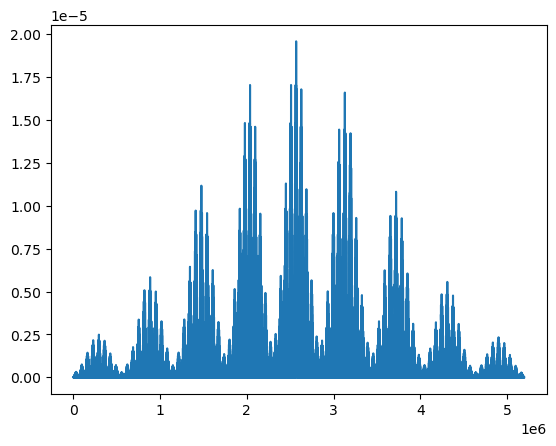

In [142]:
plt.plot(probs)

In [145]:
with open('nummeric_results/2d-algo.pkl', 'wb') as f:
    pickle.dump({'probs':probs,'final_state':final_state},f)

In [150]:
np.unique([[1,1,2],[1,1,3],[1,1,2]], axis = 0)

array([[1, 1, 2],
       [1, 1, 3]])

In [151]:
uni = np.unique(final_state, axis = 0)

In [152]:
len(uni)

1154736

In [154]:
len(final_state)/len(uni)

4.5

# Solve as two dimensional

In [164]:
# x(t-tau), x(t), res
R = np.zeros(( N_x,N_x, N_x))


F = force(x_s)
#Fm = (F[1:]+F[:-1])/2
lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i


R[:,0,0] = -lp
R[:,-1,-1] = -ln
R[:,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
R[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,None]
R[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,None]
prop = expm(R*dt, )
#    return prop

In [165]:
steps = 20
i_zero = np.argmin(x_s**2)
states = np.full((1,ntau+1),i_zero,dtype=int)
probs = np.array([1.])
total_prob = [1]

hists = np.empty((steps,N_x))

# states = np.array([
# [40, 40, 40, 40, 40, 40],
# [10, 40, 40, 40, 40, 60]
# ])
# probs = [0.5,0.5]

for i in tqdm(np.arange(steps)):
    a_s = np.swapaxes(prop,1,2)[states[:,0],states[:,-1],:]
    print('-------')
    
    total_probs = a_s*probs[:,None]
    i_s = np.where(total_probs > 0.0000005)
    new_probs = total_probs[i_s]
    new_states = np.repeat(states[:,None,:],N_x, axis = 1,)[i_s]
    new_states[:,:-1] = new_states[:,1:]
    new_states[:,-1]  = i_s[1]

    
    uni, indxs = np.unique(new_states, axis=0, return_inverse=True)
    states = uni
    new_probs = np.stack([np.sum(new_probs[indxs == i]) for i in range(len(uni))])
    total_prob.append(np.sum(new_probs))
    probs = new_probs/np.sum(new_probs)
    
    hists[i] = [np.sum(probs[states[:,-1] == i]) for i in range(N_x)] 

    print(len(probs))

  0%|          | 0/20 [00:00<?, ?it/s]

-------
13
-------
101
-------
564
-------
2473
-------
8574
-------
23858
-------
22580
-------
23958
-------
25634
-------
27748
-------
30224
-------
32057
-------
33287
-------
34040
-------
34585
-------
34923
-------
35098
-------
35303
-------
35564
-------
35855


In [166]:
states[len(states)//2-10:len(states)//2+10]

array([[ 8,  7,  6,  7,  5,  6],
       [ 8,  7,  6,  7,  5,  7],
       [ 8,  7,  6,  7,  6,  3],
       [ 8,  7,  6,  7,  6,  4],
       [ 8,  7,  6,  7,  6,  5],
       [ 8,  7,  6,  7,  6,  6],
       [ 8,  7,  6,  7,  6,  7],
       [ 8,  7,  6,  7,  6,  8],
       [ 8,  7,  6,  7,  7,  4],
       [ 8,  7,  6,  7,  7,  5],
       [ 8,  7,  6,  7,  7,  6],
       [ 8,  7,  6,  7,  7,  7],
       [ 8,  7,  6,  7,  7,  8],
       [ 8,  7,  6,  7,  7,  9],
       [ 8,  7,  6,  7,  7, 10],
       [ 8,  7,  6,  7,  8,  5],
       [ 8,  7,  6,  7,  8,  6],
       [ 8,  7,  6,  7,  8,  7],
       [ 8,  7,  6,  7,  8,  8],
       [ 8,  7,  6,  7,  8,  9]])

In [167]:
total_prob

[1,
 0.9999997136878961,
 0.9999943302830545,
 0.9999533618168308,
 0.9997485785964009,
 0.9988095628652467,
 0.9954701427574048,
 0.9864698152876274,
 0.9874729912837922,
 0.9866305784532166,
 0.9854906972956388,
 0.984072191197821,
 0.9823834127547773,
 0.9810556064958185,
 0.980096085479371,
 0.979698842108764,
 0.9795283949920937,
 0.9794959063399045,
 0.9795005783004659,
 0.9794226810841684,
 0.9792746922365496]

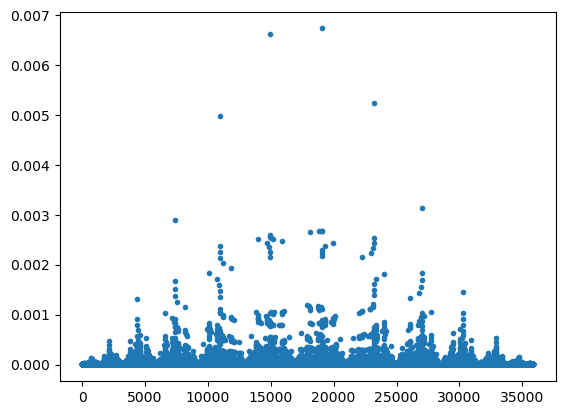

In [168]:
plt.plot(probs,'.')

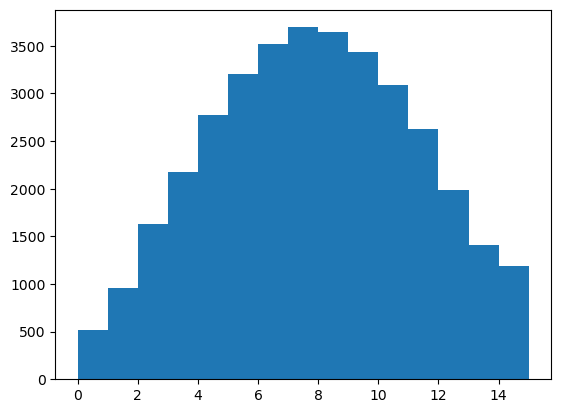

In [169]:
plt.hist(states[:,-1], bins = np.arange(0,N_x))
plt.show()

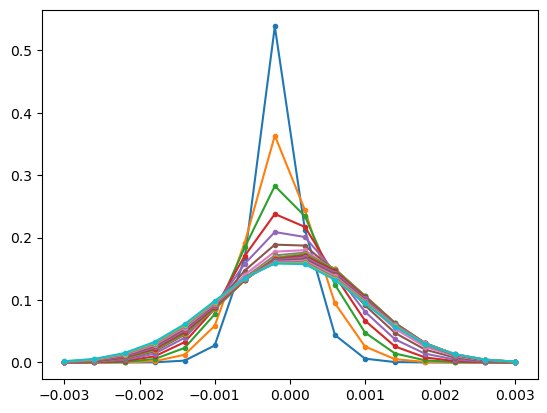

In [170]:
#cum_probs = np.stack([[np.sum(probs[states[:,j] == i]) for i in range(N_x)] for j in range(ntau+1)])
for hist in hists:
    plt.plot(x_s,hist,'.-')

In [171]:
def simulate_traj(N_p, N_loop, N_t, ntau, s, dt, border, force):
    pos = np.empty((N_loop,N_p,N_t))
    vel = s*np.random.randn(N_loop,N_p,N_t)*1/np.sqrt(dt)

    pos[:,:,:ntau+1] = -border
    vel[:,:,:ntau+1] = 0

    for i in range(ntau+1,N_t):
        pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
        vel[:,:,i] += force(pos[:,:,i-ntau])
    return pos

In [177]:
f = 6

pos = simulate_traj(N_p=30_000, N_loop=1, N_t=(steps+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=0, force=force)
sim_hists = [np.histogram(np.sum(pos, axis=0)[:,j], bins = bins)[0] for j in range(pos.shape[-1])]

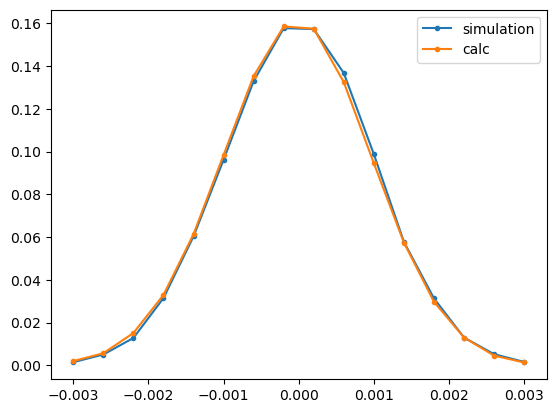

In [180]:
idx = steps-1
plt.plot(x_s,sim_hists[(ntau+idx+2)*f]/sim_hists[(ntau+idx+2)*f].sum(),'.-', label = 'simulation')
plt.plot(x_s,hists[idx],'.-', label='calc')
plt.legend()